# Chapter 6: 학습 관련 기술들
---

* 신경망 학습의 핵심 개념들: 가중치 매개변수의 최적값 탐색 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등
* 정규화 방법: 가중치 감소, 드롭아웃
   
-> **신경망 학습의 효유고하 정확도 상승**

##### 6.1 매개변수 갱신

* 최적화: 매개변수의 최적값을 찾는 문제(손실함수의 값을 가능한 한 낮추는 매개변수를 탐색)
* 기울기를 통해 최적값에 다가감 -> **확률적 경사 하강법(SGD)**

$SGD: W \leftarrow W - \eta \frac{\partial L}{\partial W}$

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key]  -= self.lr * grads[key]

**SGD의 단점**   
예시: $f(x,y) = \frac{1}{20}x^2 + y^2$

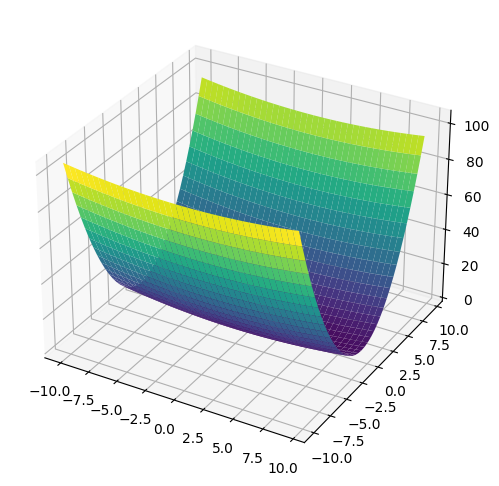

In [2]:
# 예시함수 그래프
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
XX, YY = np.meshgrid(X, Y)
ZZ = (1 / 20) * XX**2 + YY**2

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, cmap="viridis")



예시함수의 최솟값은 $(x, y) = (0,0)$ 이지만 실제로 기울기는 대부분 (0,0) 방향을 가리키지 않는다.

<img src="./img/ch6-1.png" width="350">   

실제로 SGD에 적용해보면 다음과 같이 지그재그로 이동하며 최솟값에 다가가서 비효율적이다.

<img src="./img/ch6-2.png" width="350">    

-> 비등방성 함수에서는 탐색 경로가 비효율적 -> **모멘텀, AdaGrad, Adam**

**모멘텀(Momentum, 운동량)**   
$ W \leftarrow W + v \ , \ v \leftarrow \alpha v - \eta \frac{\partial L} {\partial W}$ ($v$는 속도)

: 공이 그릇의 바닥을 구르듯 움직인다.

In [3]:
# 모멘텀 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.item():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

모멘텀에 의한 최적화 갱신 경로   

<img src="./img/ch6-3.png" width="400">

위에도 나와 있듯이 갱신 경로는 공이 그릇 바닥을 구르듯 움직인다.   
SGD와 비교했을 때 지그재그 정도가 덜한데, 이는 x축의 힘은 아주 작지만 방향은 변하지 않아 한 방향으로 일정하게 가속하기 때문

**AdaGrad**   
학습률 감소: 학습을 진행하면서 학습률을 점차 줄여나가는 방법   
AdaGrad는 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행 (=> Adaptive Grad)

$ W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L} {\partial W} \ , \ h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}$

h 는 기존 기울기의 제곱 -> 매개변수를 갱신할 때 $\frac{1}{\sqrt{h}}$에 의해 학습률 조정 = 많이 움직인(크게 갱신된) 원소는 학습률이 낮아짐.

In [4]:
# AdaGrad 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))

AdaGrad에 의한 최적화 갱신 경로

<img src="./img/ch6-4.png" width=400>

y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정

**RMSProp**   
AdaGrad의 경우 과거의 기울기를 제곱하여 계속 더해감 -> 학습을 진행할수록 갱신 강도도 약해짐   

=> 과거의 모든 기울기를 균일하게 더해가는 것이 아니라 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영 (지수이동평균)

**Adam**   
AdaGrad X Momentum

<img src="./img/ch6-5.png" width=400>

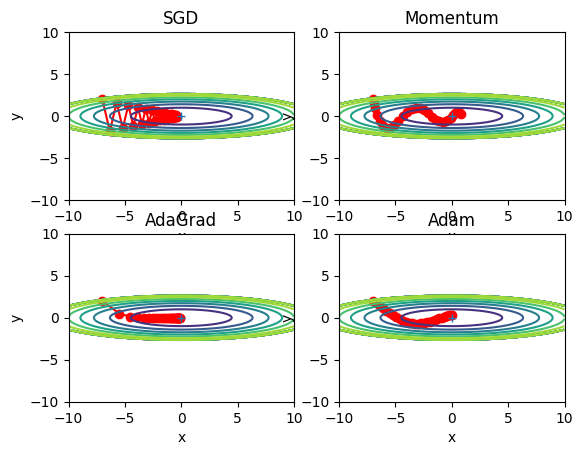

In [5]:
# SGD, Momentum, AdaGrad, Adam 결과
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

유감스럽게도 모든 문제에서 항상 뛰어난 기법은 아직 없다. -> 각자의 장단을 사용하여 해결

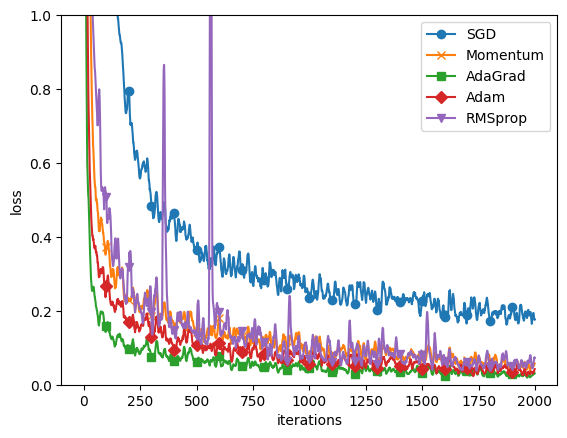

In [6]:
# MNIST 데이터셋에 대한 학습 진도 비교
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "v"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

##### 6.2 가중치의 초깃값

* 가중치의 초깃값을 무엇을 설정하느냐가 신경망 학습의 성패를 가를 수 있다.
   
* **가중치 감소**   
:가중치 매개변수의 값이 작아지도록 하여 오버피팅이 일어나지 않게 하는 학습기법

* 가중치의 초깃값을 0으로 설정하면(또는 균일하게 설정하면) 가중치를 여러 개 갖는 의미를 사라지게 함
* 힌트는 은닉층의 활성화 값이다. -> 초깃값에 따라 은닉층 활성화 값이 어떻게 변화하는지 살펴보자.

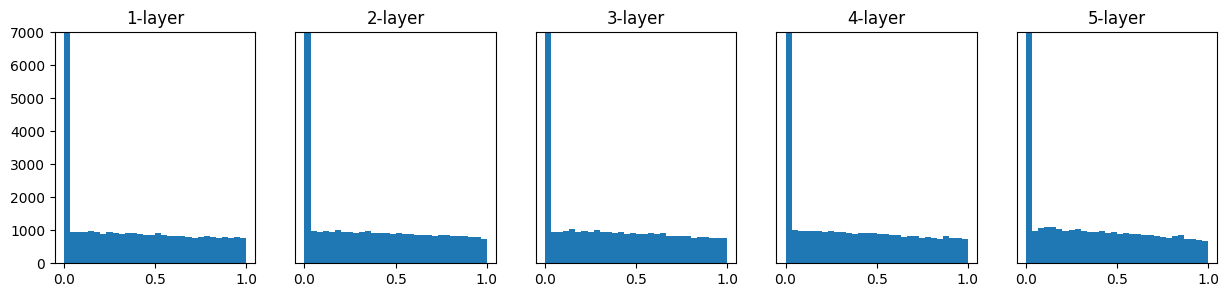

In [7]:
# 가중치 초깃값에 따른 각 층의 활성화값 분포
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

plt.figure(figsize=(15,3))
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

* 시그모이드 함수

<img src="./img/ch6-6.png" width=1000>   

가중치 값이 표준편차가 1인 정규분표 초기화 했을 때 각 층의 활성화 값 분포는 0과 1에 치우쳐저 있는것을 알 수 있다.   
이 경우 역전파 때 시그모이드 함수를 미분하면 미분값이 0 에 다가가기 때문에 기울기가 점점 작아지다 사라진다. (기울기 소실)
   

<img src="./img/ch6-7.png" width=1000>   

반면, 0.01로 했을 때는 활성화 값 분포가 0.5 부근에 집중된 것을 알 수 있다.   
다수의 뉴런이 거의 같은 값을 출력하면 뉴런을 여러개 둔 의미가 없어진다. (표현력 제한)   

<img src="./img/ch6-8.png" width=1000>   

표준 편차가 $\frac{1}{\sqrt{n}}$인 분포는 앞의 값들보다 활성화값이 더 넓게 분포됨을 볼 수 있다.(Xavier 초깃값)


* Relu 함수   

표준편차: 0.01   

<img src="./img/ch6-9.png" width=1000>   

Xavier 초깃값   

<img src="./img/ch6-10.png" width=1000>   

He 초깃값   

<img src="./img/ch6-11.png" width=1000> 

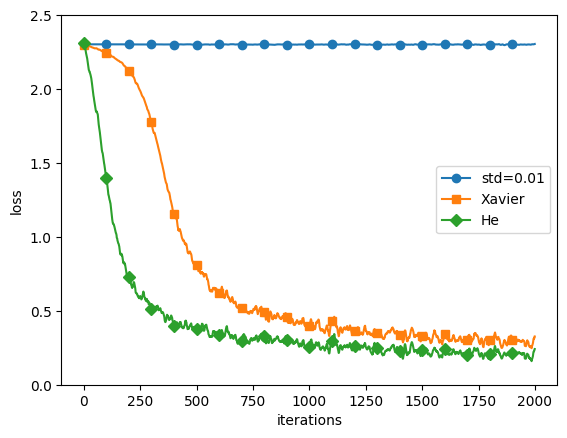

In [8]:
# MNIST 데이터셋으로 본 가중치 초깃값 비교
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

##### 6.3 배치 정규화   

배치 정규화의 장점
* 학습을 빨리 진행
* 초깃값에 크게 의존하지 않음
* 오버피팅 억제

<img src="./img/ch6-12.png" width=1000>   
   
배치 정규화: 미니배치 입력 데이터를 평균이 0, 분산이 1이 되도록 정규화   
<img src="./img/ch6-13.png" width=900>   

$\mu_\beta \leftarrow \frac{1}{m} \sum_{i=1}^m x_i$   (평균)   
$\sigma_\beta^2 \leftarrow \frac{1}{m} \sum_{i=1}^m (x_i - \mu_\beta)^2$    (분산)   
$\hat x_i \leftarrow \frac{x_i - \mu_\beta}{\sqrt{\sigma_\beta^2 + \varepsilon}}$

배치 정규화 식: $y_i \leftarrow \gamma \hat x_i + \beta$    ($\gamma$: 확대, $\beta$: 이동)

실선이 배치 정규화를 사용한 경우, 점선이 사용하지 않은 경우


c:\Users\supli\Documents\Repo\DeepLearning\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
c:\Users\supli\Documents\Repo\DeepLearning\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


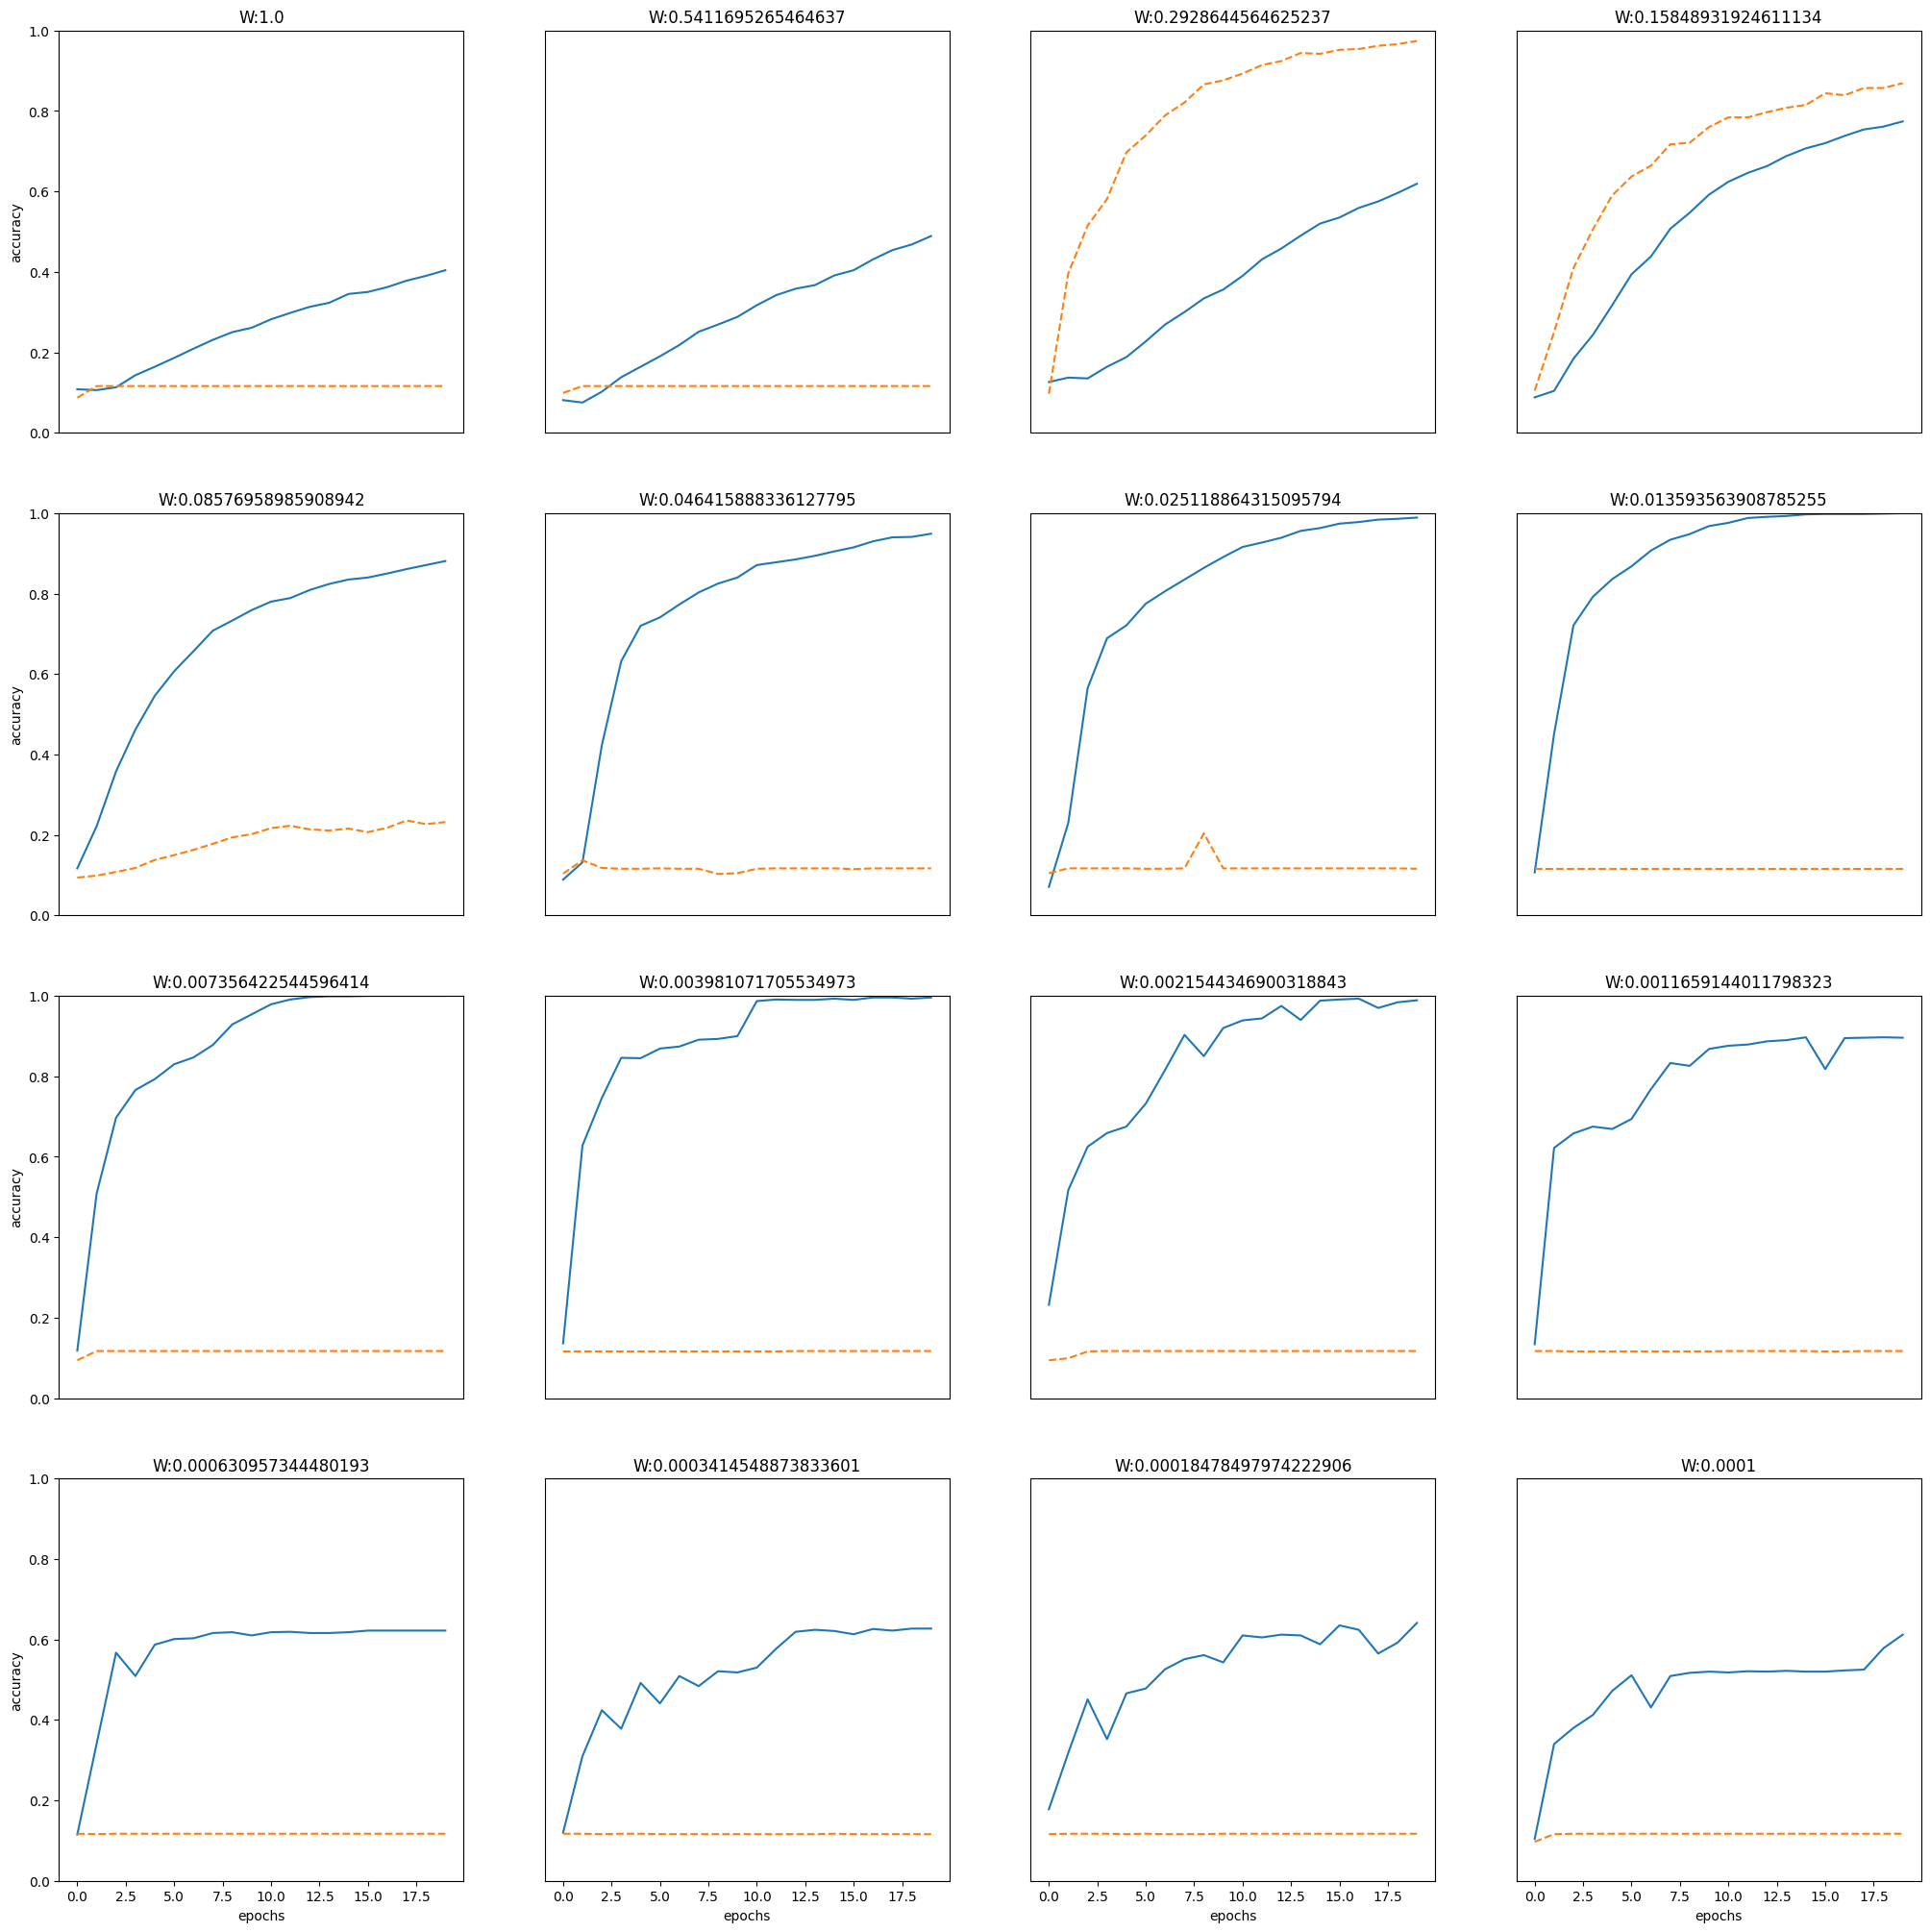

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

print("실선이 배치 정규화를 사용한 경우, 점선이 사용하지 않은 경우")
# 그래프 그리기==========
plt.figure(figsize=(25,25))
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.show()

대부분의 경우에서 배지 정규화를 상용할 때의 학습진도가 더 빠른것으로 나타난다.   

**배치 정규화를 사용함으로써 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 된다.**

##### 6.4 바른 학습을 위해

오버피팅: 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태   
   
오버피팅이 주로 발생하는 경우
* 매개변수가 많고 표현력이 높은 모델 (과다하게 복잡)
* 훈련 데이터가 적음


In [10]:
# 오버피팅을 일으키기 위해 MNIST 데이터를 300개, 7층 네트워크를 사용
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(int(1e9)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

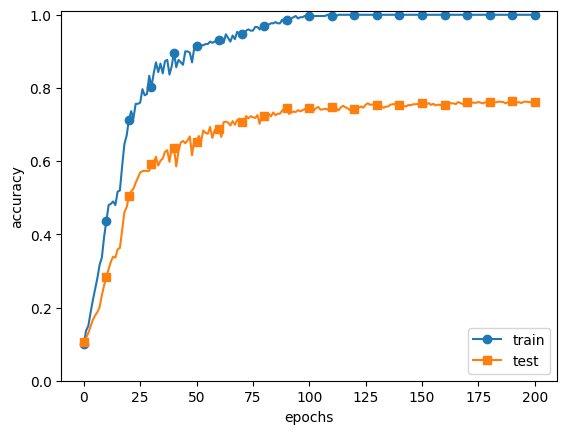

In [11]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.01)
plt.legend(loc='lower right')
plt.show()

**가중치 감소**

: 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제   
Ex) 손실함수에 L2 규제를 더함 -> 가중치 감소 = $\frac{1}{2}\lambda W^2$ ($\lambda$는 정규화 세기(클수록 큰 중치에 대한 패널티가 커짐))

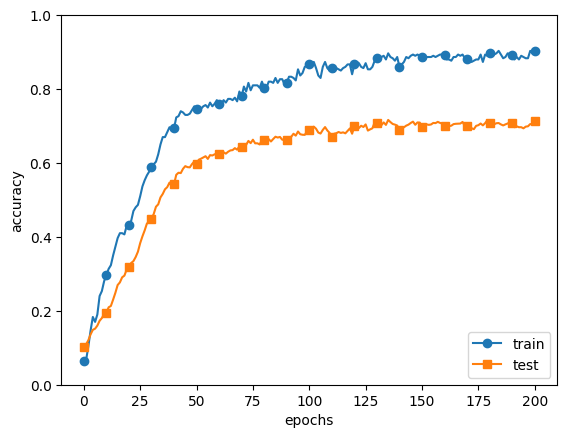

In [12]:
# 가중치 감소를 적용
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

* 훈련 데이터와 시험 데이터 정확도 차이가 줄었다.
* 훈련 데이터의 정확도가 100%에 달하지 못했다.

**드롭아웃**   
: 뉴런을 임의로 삭제하면서 학습하는 방법

<img src="./img/ch6-14.png" width=800>

In [13]:
# 드롭아웃 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_fig=True):
        if train_fig:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

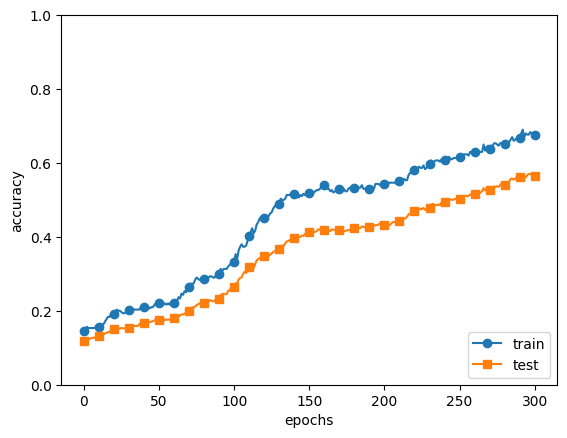

In [28]:
# 드롭아웃 적용 결과
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

##### 6.5 적절한 하이퍼파라미터 값 찾기    
하이퍼파라미터 예: 각 층의 뉴런 수, 배치 크기, 학습률, 가중치 감소 등

**검증 데이터**   
: 하이퍼파라미터 조정용 데이터 

In [15]:
from common.util import *
# 검증 데이터 분리
(x_train, x_test), (t_train, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, x_test)

# 20% 를 검증 데이터로 분할
validation_rate = 0.20
valdiation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:valdiation_num]
t_val = t_train[:valdiation_num]
x_train = x_train[valdiation_num:]
t_train = t_train[:valdiation_num]

**검증 데이터를 사용하여 하이퍼파라미터를 최적화** -> 최적값이 존재하는 범위를 조금씩 좁혀감   

* 0단계: 하이퍼파라미터 값의 범위를 설정   
* 1단계: 설정된 범위에서 하이퍼파라미터 값을 무작위로 추출   
* 2단계: 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습, 검증 데이터로 평가(에폭은 작게)   
* 3단계: 1, 2단계를 반복하여 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁혀나감

In [18]:
# 하이퍼파라미터 최적화 구현
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    # print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.8) | lr:0.007944431937319418, weight decay:7.006978145476316e-06
Best-2(val acc:0.79) | lr:0.008735842000488573, weight decay:7.927778766196606e-07
Best-3(val acc:0.75) | lr:0.0063550950210513645, weight decay:5.687536859204687e-08
Best-4(val acc:0.72) | lr:0.008707918739683865, weight decay:2.6735592548855216e-06
Best-5(val acc:0.72) | lr:0.006370722424520573, weight decay:1.873608240457748e-07
Best-6(val acc:0.72) | lr:0.006374860301501163, weight decay:1.3604965267692918e-08
Best-7(val acc:0.66) | lr:0.005526098047397154, weight decay:1.8648866755685134e-05
Best-8(val acc:0.66) | lr:0.003919330317973326, weight decay:4.908940964663538e-05
Best-9(val acc:0.65) | lr:0.004948063361253034, weight decay:1.0646643407857211e-05
Best-10(val acc:0.62) | lr:0.004061082142177299, weight decay:1.540294680647203e-08
Best-11(val acc:0.62) | lr:0.0052787115157667324, weight decay:6.11705538548146e-07
Best-12(val acc:0.54)

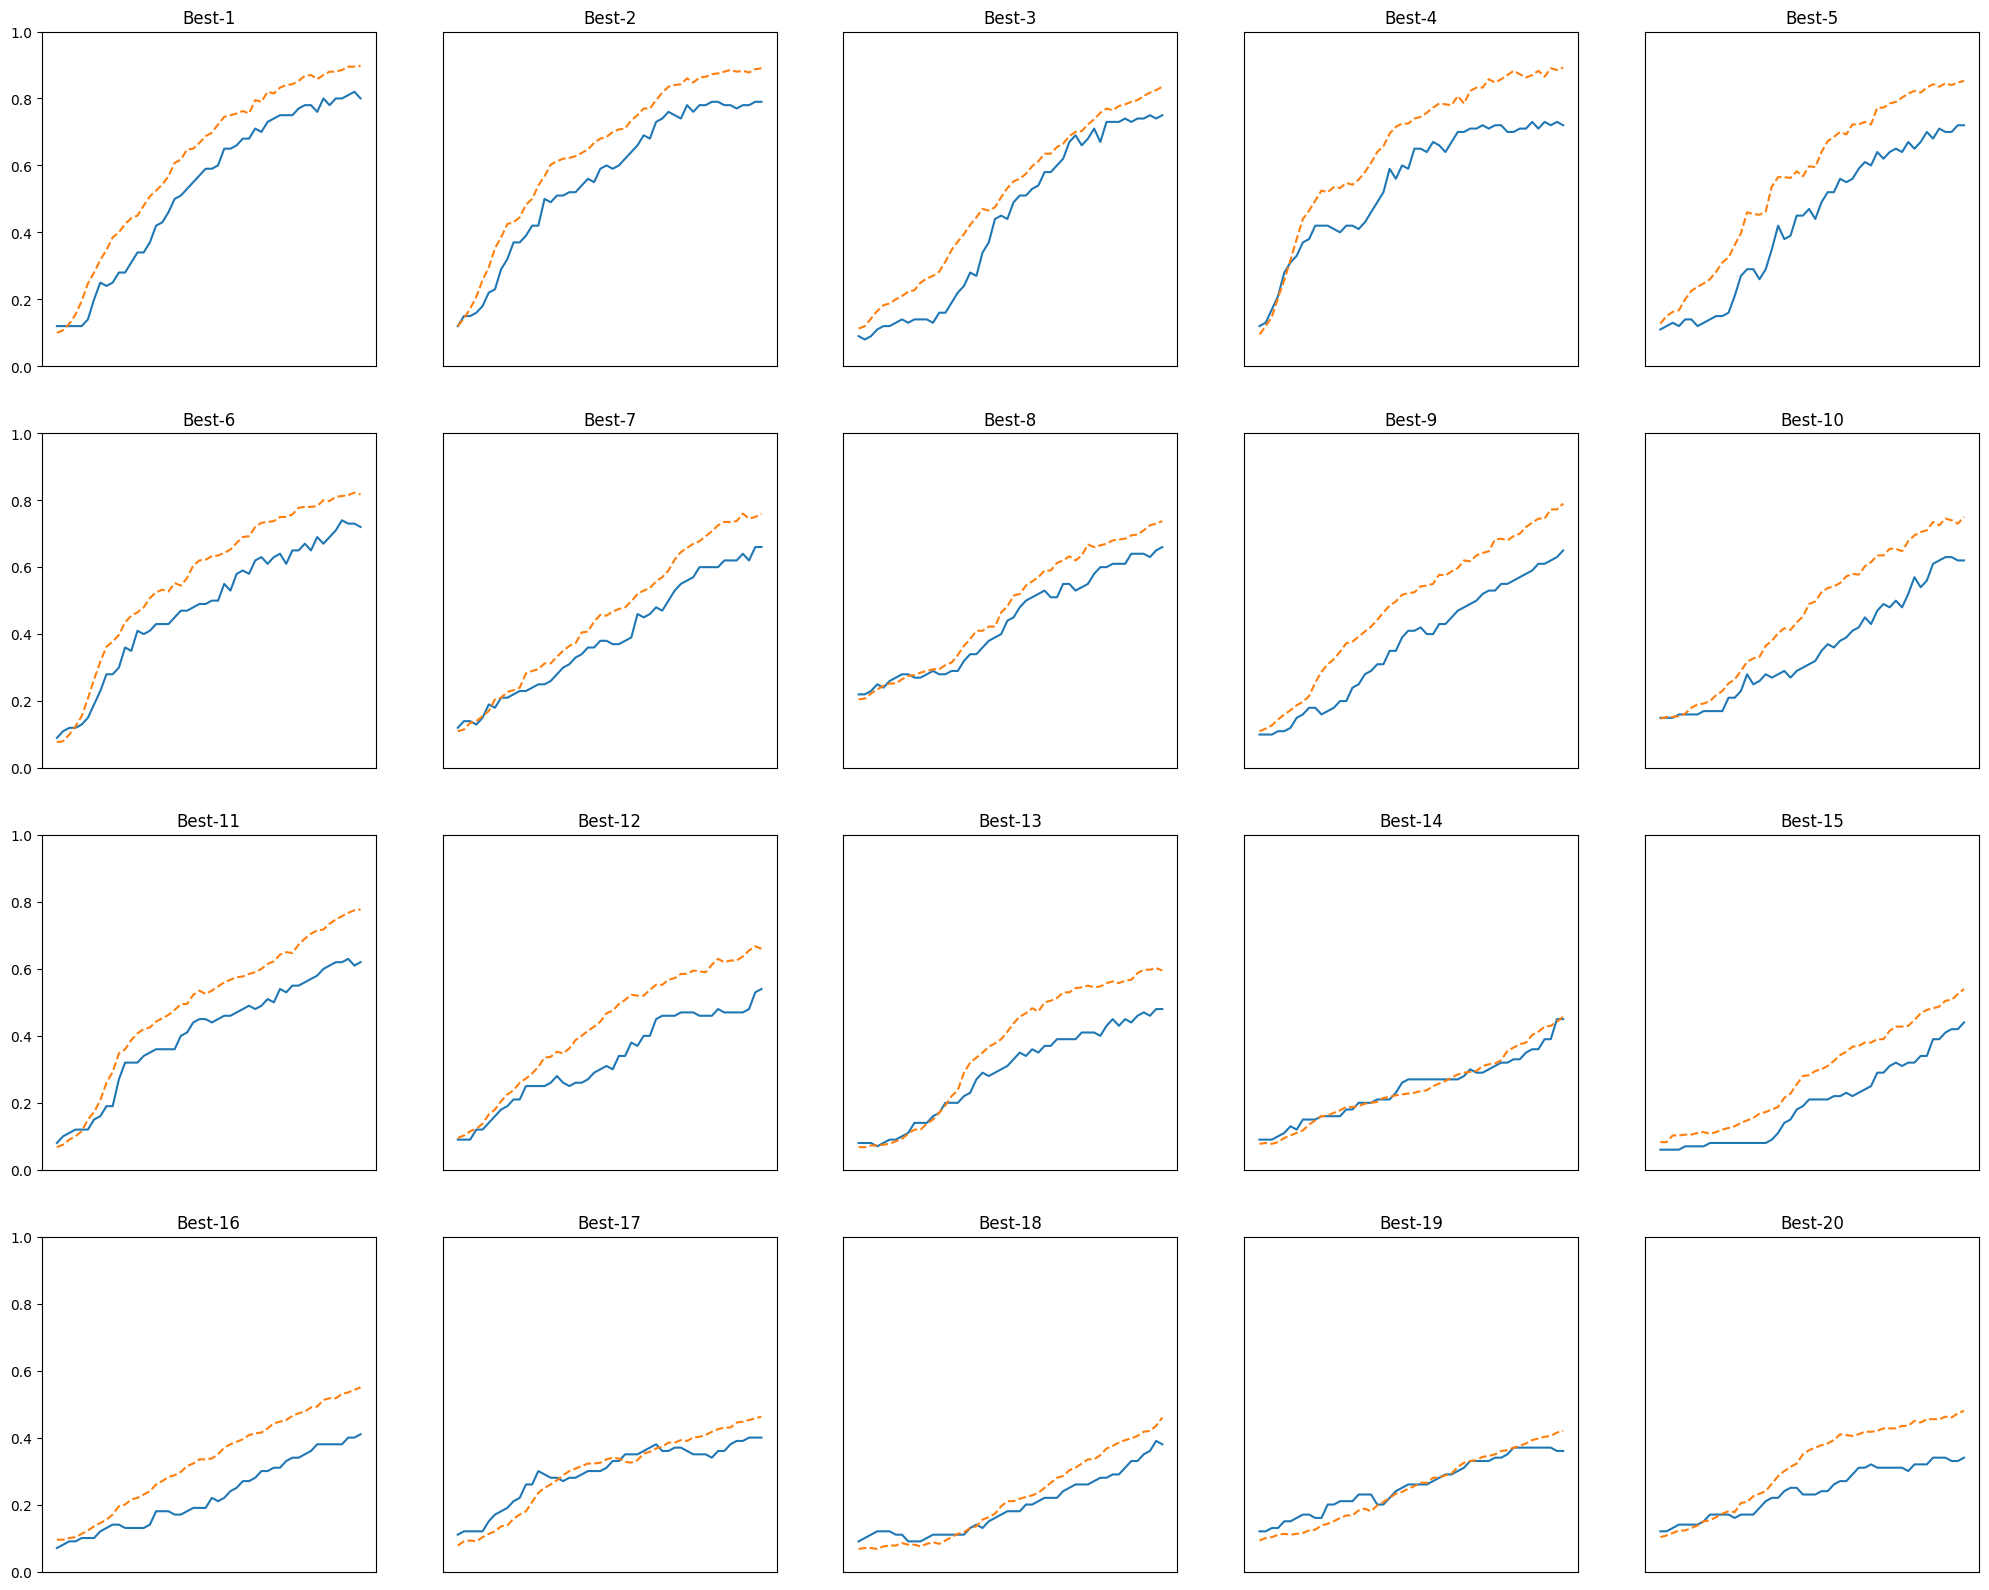

In [21]:
# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(25,20))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

Best-5를 살펴보면 학습이 잘 진행될 때 학습률은 0.001~0.01, 가중치 감소 계수는 $10^{-8}$ ~ $10^{-6}$정도인 것을 알 수 있다.

In [23]:
# 학습률 0.001 ~ 0.01 , 가중치 감소 계수 10^-8 10^-6 사이 값을 시물레이션
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -6)
    lr = 10 ** np.random.uniform(-3, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    # print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.8) | lr:0.008740957504362533, weight decay:1.2055562658409766e-08
Best-2(val acc:0.78) | lr:0.009682767443826, weight decay:1.6615837276420708e-08
Best-3(val acc:0.78) | lr:0.009766815320447047, weight decay:1.3870867858712168e-07
Best-4(val acc:0.77) | lr:0.008676133097398644, weight decay:3.393460294682595e-07
Best-5(val acc:0.77) | lr:0.006609585412500645, weight decay:1.9179512280030042e-08
Best-6(val acc:0.76) | lr:0.00904623639085086, weight decay:1.298889505331834e-08
Best-7(val acc:0.76) | lr:0.008677183529859663, weight decay:2.619285723254697e-07
Best-8(val acc:0.75) | lr:0.0062656107461526, weight decay:5.2901258137521855e-08
Best-9(val acc:0.74) | lr:0.007890959052826016, weight decay:1.0164629022059921e-07
Best-10(val acc:0.73) | lr:0.0058400649664343525, weight decay:6.519167051411457e-07
Best-11(val acc:0.72) | lr:0.008130667823984222, weight decay:1.0222074432141613e-07
Best-12(val acc:0.71) | 

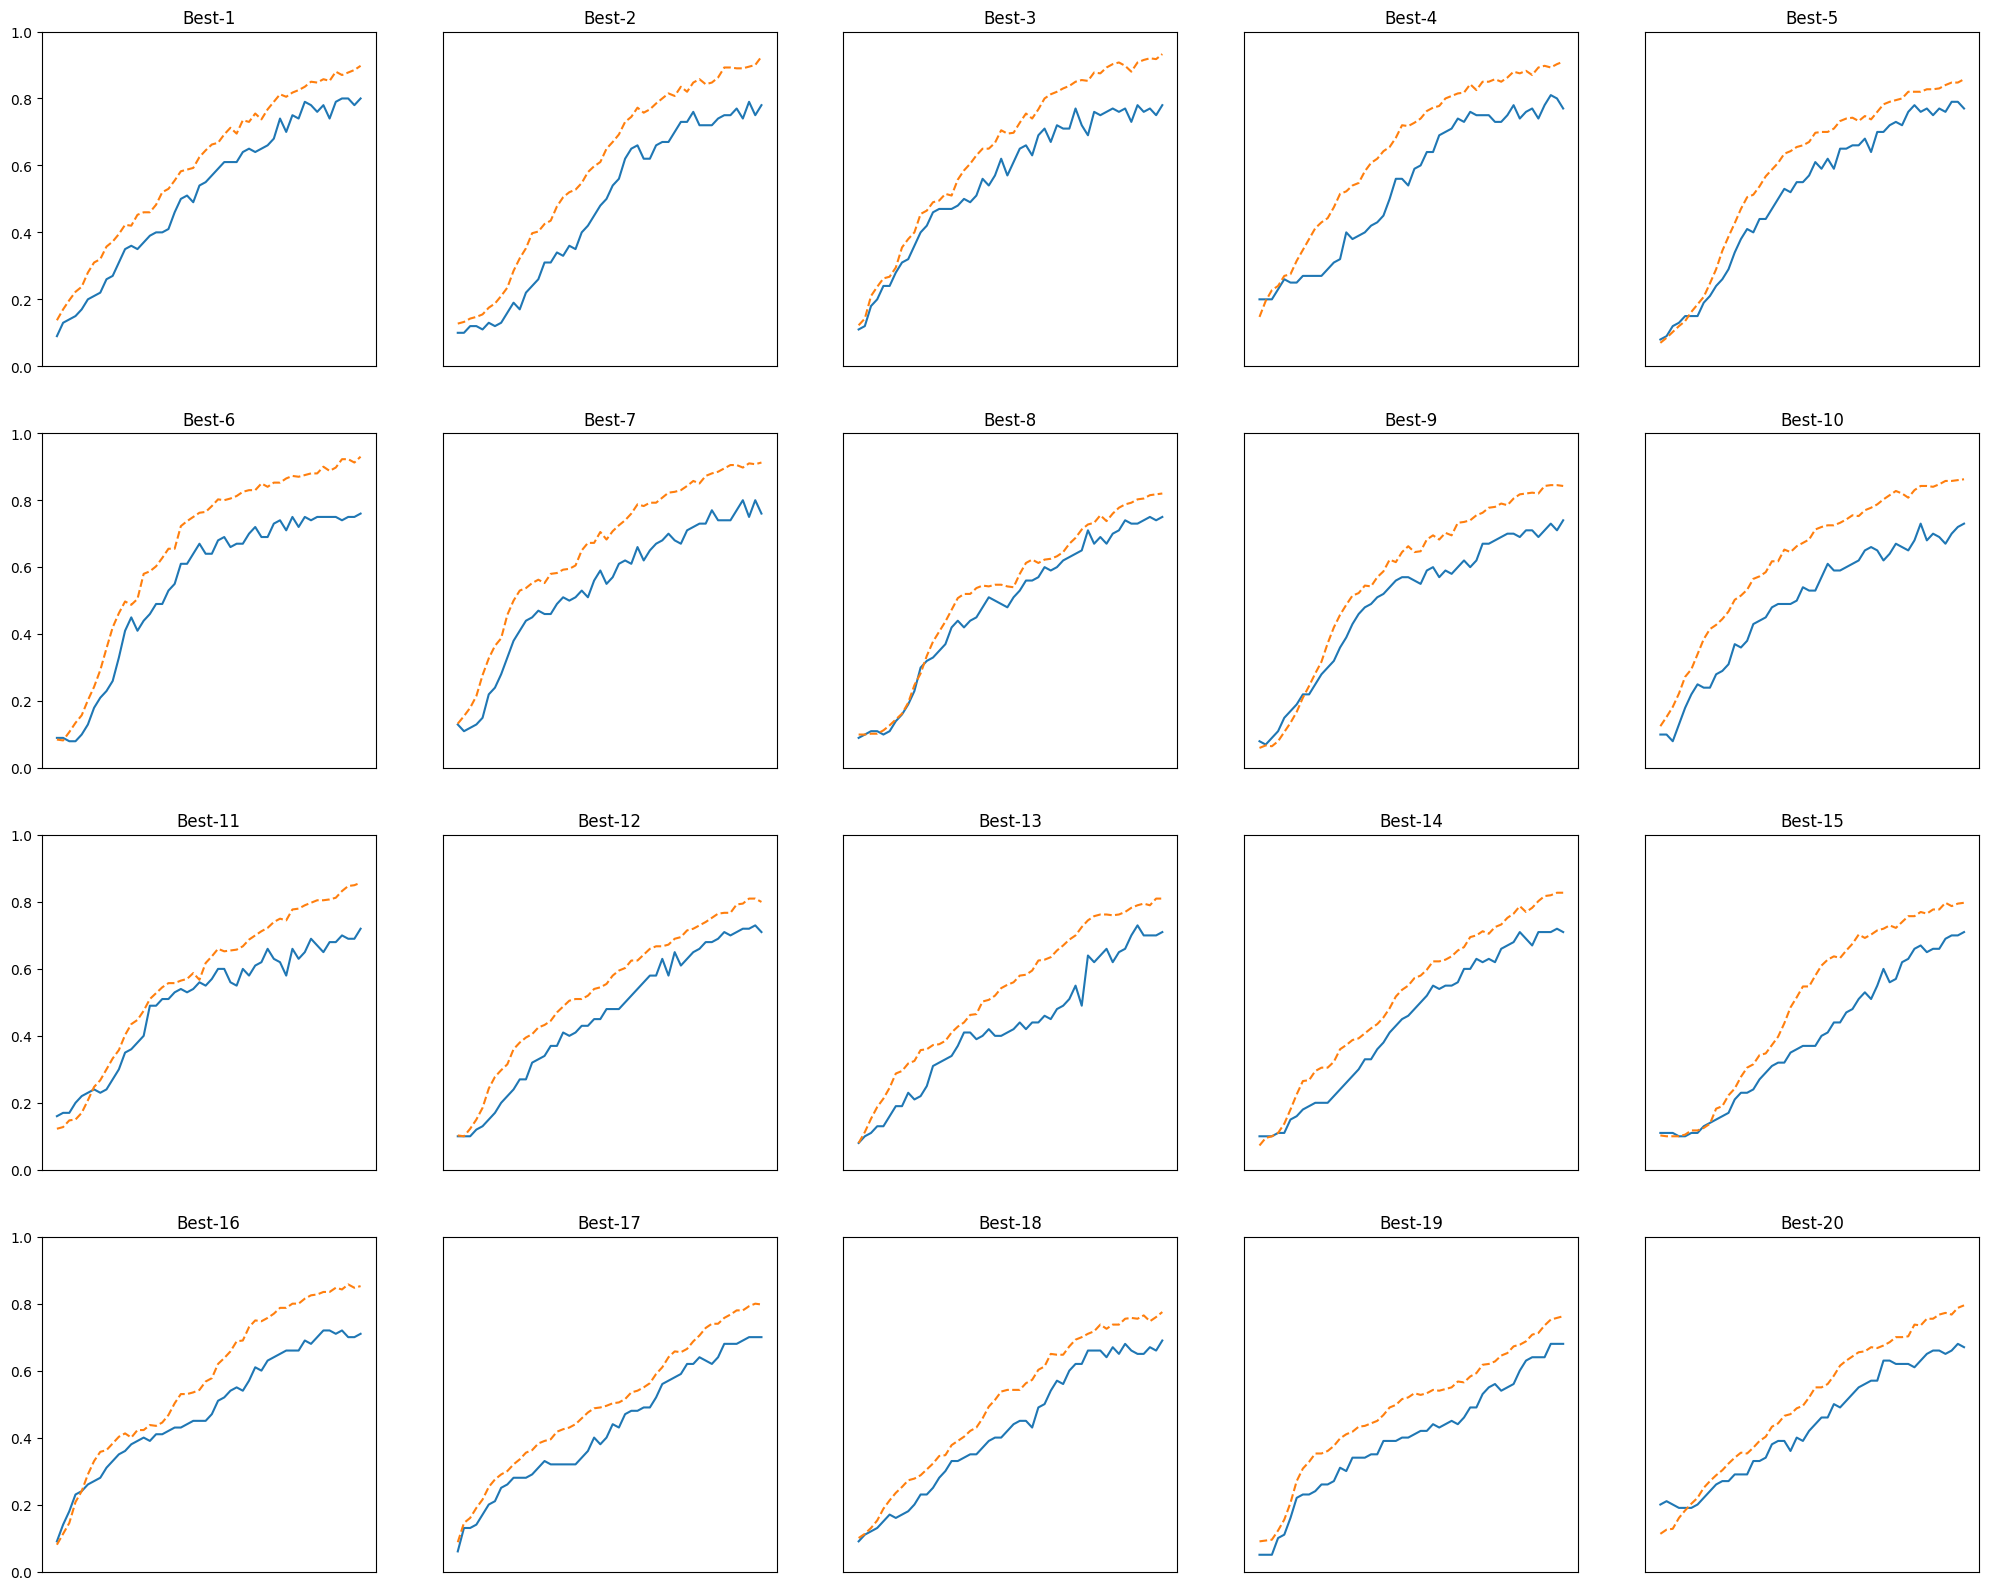

In [24]:
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(25,20))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

##### 6.6 정리